In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
from tqdm import tqdm
import argparse
import torchvision
from torch.autograd import Variable 
from torchvision import transforms

In [2]:
## Load the model 
model_conv = torchvision.models.alexnet(pretrained=True)
#Architecture of Alexnet
model_conv

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [3]:
n_class = 13
# Number of filters in the bottleneck layer
num_ftrs = model_conv.classifier[6].in_features
# convert all the layers to list and remove the last one
features = list(model_conv.classifier.children())[:-1]
## Add the last layer based on the num of classes in our dataset
features.extend([nn.Linear(num_ftrs, n_class)])
## convert it into container and add it to our model class.
model_conv.classifier = nn.Sequential(*features)

In [4]:
model_conv

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [5]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, use_gpu, num_epochs=25, mixup = False, alpha = 0.1):
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    print("MIXUP".format(mixup))
    since = time.time()
    
    # graphs
    loss_values_train = []
    loss_values_valid = []
    acc_values_train = []
    acc_values_valid = []

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data
                
                #augementation using mixup
                if phase == 'train' and mixup:
                    inputs = mixup_batch(inputs, alpha)
                    
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                if type(outputs) == tuple:
                    outputs, _ = outputs
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'train':
                loss_values_train.append(epoch_loss)
                acc_values_train.append(epoch_acc)
            else:
                loss_values_valid.append(epoch_loss)
                acc_values_valid.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, ((loss_values_train, acc_values_train), (loss_values_valid, acc_values_valid))

In [6]:
## Loading the dataloaders -- Make sure that the data is saved in following way
"""
data/
  - train/
      - class_1 folder/
          - img1.png
          - img2.png
      - class_2 folder/
      .....
      - class_n folder/
  - val/
      - class_1 folder/
      - class_2 folder/
      ......
      - class_n folder/
"""

data_dir = "RESISC13"
input_shape = 224
batch_size = 32
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
scale = 360
input_shape = 224
use_parallel = True
use_gpu = True
epochs = 10

data_transforms = {
        'train': transforms.Compose([
        transforms.Resize(scale),
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
        'val': transforms.Compose([
        transforms.Resize(scale),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),}

data_transforms = {
        'train': transforms.Compose([
        transforms.Resize(scale),
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
        'val': transforms.Compose([
        transforms.Resize(scale),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),}



image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                         shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print (class_names)
print (dataset_sizes)

# if use_parallel:
#     print("[Using all the available GPUs]")
#     model_conv = nn.DataParallel(model_conv, device_ids=[0, 1])

print("[Using CrossEntropyLoss...]")
criterion = nn.CrossEntropyLoss()

print("[Using small learning rate with momentum...]")
optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())), lr=0.001, momentum=0.9)

print("[Creating Learning rate scheduler...]")
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print("[Training the model begun ....]")
# train_model function is here: https://github.com/Prakashvanapalli/pytorch_classifiers/blob/master/tars/tars_training.py
model_ft, t = train_model(model_conv, dataloaders, dataset_sizes, criterion, optimizer_conv, exp_lr_scheduler, use_gpu,
                     num_epochs=epochs)

['beach', 'chaparral', 'cloud', 'desert', 'forest', 'island', 'lake', 'meadow', 'mountain', 'river', 'sea_ice', 'snowberg', 'wetland']
{'train': 1950, 'val': 1950}
[Using CrossEntropyLoss...]
[Using small learning rate with momentum...]
[Creating Learning rate scheduler...]
[Training the model begun ....]


  0%|          | 0/61 [00:00<?, ?it/s]

MIXUP
Epoch 0/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0448 Acc: 0.5313


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0336 Acc: 0.6369

Epoch 1/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0283 Acc: 0.7000


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0277 Acc: 0.6959

Epoch 2/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0234 Acc: 0.7508


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0194 Acc: 0.8077

Epoch 3/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0212 Acc: 0.7703


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0188 Acc: 0.8041

Epoch 4/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0202 Acc: 0.7862


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0183 Acc: 0.8231

Epoch 5/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0194 Acc: 0.7954


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0145 Acc: 0.8503

Epoch 6/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0175 Acc: 0.8185


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0144 Acc: 0.8508

Epoch 7/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0138 Acc: 0.8518


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0122 Acc: 0.8728

Epoch 8/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0125 Acc: 0.8651


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.0119 Acc: 0.8779

Epoch 9/9
----------


  0%|          | 0/61 [00:00<?, ?it/s]

train Loss: 0.0128 Acc: 0.8662


100%|██████████| 61/61 [00:03<00:00, 22.80it/s]

val Loss: 0.0122 Acc: 0.8749

Training complete in 1m 46s
Best val Acc: 0.877949


In [7]:
import matplotlib.pyplot as plt

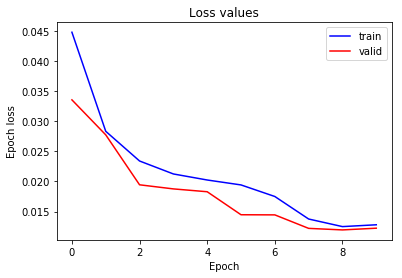

In [8]:
x = range(10)
plt.figure()
plt.plot(x, t[0][0], "b", label="train")
plt.plot(x, t[1][0], "r", label="valid")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Epoch loss")
plt.legend()
plt.show()

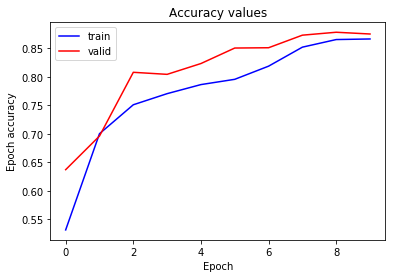

In [9]:
x = range(10)
plt.figure()
plt.plot(x, t[0][1], "b", label="train")
plt.plot(x, t[1][1], "r", label="valid")
plt.title("Accuracy values")
plt.xlabel("Epoch")
plt.ylabel("Epoch accuracy")
plt.legend()
plt.show()